In [9]:
import shutil
import os
import glob
import json
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from IPython.display import display, HTML
import mplcursors

from config import CONFIG
from pathlib import Path

In [10]:
processed_data_pickle_path=Path(CONFIG["PROCESSED_DATA_PICKLE_PATH"])
metadata_with_utm = Path(CONFIG["METADATA_WITH_UTM"])
metadata_excel = Path(CONFIG["METADATA_EXCEL"])
metadata_pickle = Path(CONFIG["METADATA_PICKLE"])



In [11]:
df=pd.read_pickle(processed_data_pickle_path)

In [12]:
# Leer el archivo JSON
with open(metadata_with_utm, 'r') as file:
    data = json.load(file)

# Aplanar el JSON anidado en un DataFrame
df_metadata = pd.json_normalize(data)

# Guardar el DataFrame en un archivo Excel
df_metadata.to_excel(metadata_excel, index=False)

# Guardar el DataFrame en un archivo pickle
df_metadata.to_pickle(metadata_pickle)

print("Archivos 'data.xlsx' y 'data.pkl' creados correctamente.")

Archivos 'data.xlsx' y 'data.pkl' creados correctamente.


In [13]:
df_metadata.head(10)

,file,gps.latitude,gps.longitude,utm.x,utm.y,utm.zone
0,1.jpg,-16.034372,-71.878069,192013.012103,8.225125e+06,19K
1,10.jpg,-16.035175,-71.875106,192331.643338,8.225040e+06,19K
2,11.jpg,-16.035175,-71.875106,192331.643338,8.225040e+06,19K
3,12.jpg,-16.035558,-71.875475,192292.669293,8.224997e+06,19K
4,13.jpg,-16.035175,-71.875106,192331.643338,8.225040e+06,19K
5,14.jpg,-16.035558,-71.875475,192292.669293,8.224997e+06,19K
6,15.jpg,-16.035558,-71.875475,192292.669293,8.224997e+06,19K
7,16.jpg,-16.035175,-71.875106,192331.643338,8.225040e+06,19K
8,17.jpg,-16.035558,-71.875475,192292.669293,8.224997e+06,19K
9,18.jpg,-16.035175,-71.875106,192331.643338,8.225040e+06,19K


In [14]:
with open(metadata_with_utm, "r", encoding="utf-8") as f:
    fotos_data = json.load(f)

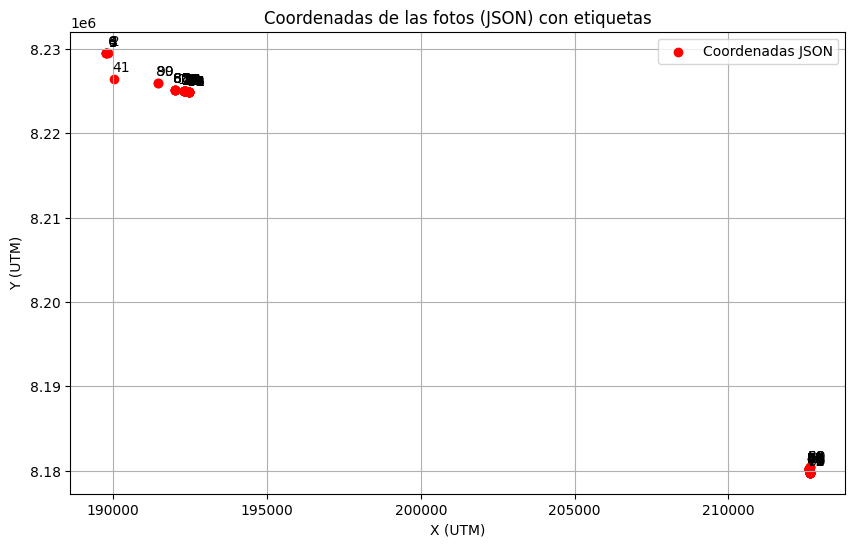

In [15]:
# 2. Extraer las coordenadas (x, y) y guardar el nombre de la foto
# Extraer las coordenadas y la etiqueta (sin extensión)
x_coords = []
y_coords = []
labels = []

for item in fotos_data:
    x_coords.append(item["utm"]["x"])
    y_coords.append(item["utm"]["y"])
    # Extraemos la etiqueta sin la extensión (por ejemplo "1" en lugar de "1.jpg")
    label = item["file"].split('.')[0]
    labels.append(label)

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_coords, y_coords, c='red', label='Coordenadas JSON')

# Añadir la etiqueta de cada punto
for x, y, label in zip(x_coords, y_coords, labels):
    ax.annotate(label, (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

ax.set_xlabel("X (UTM)")
ax.set_ylabel("Y (UTM)")
ax.set_title("Coordenadas de las fotos (JSON) con etiquetas")
ax.legend()
ax.grid(True)
plt.show()


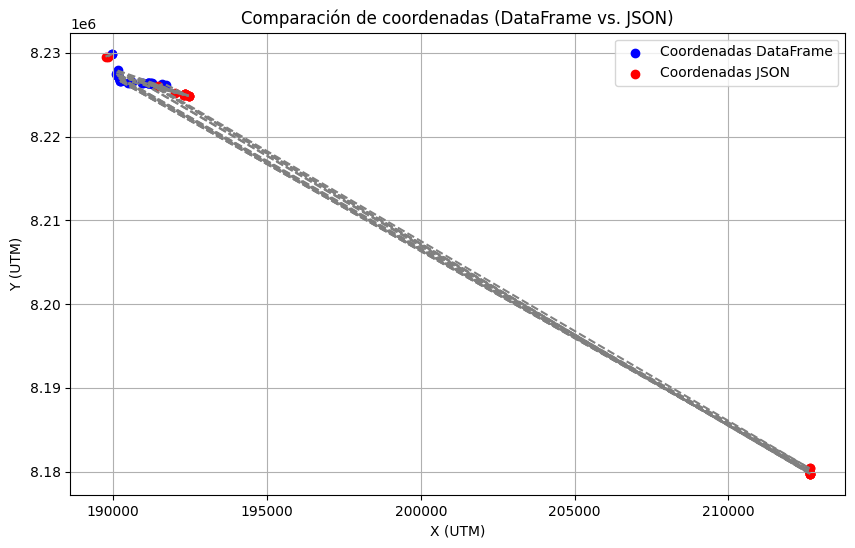

In [16]:
foto_coords = {}
for item in fotos_data:
    # "file" es algo como "1.jpg", "10.jpg", etc.
    file_name = item["file"]
    # Quitamos la extensión .jpg para quedarnos con "1", "10", etc.
    foto_id = file_name.split(".")[0]
    
    x_utm = item["utm"]["x"]
    y_utm = item["utm"]["y"]
    foto_coords[foto_id] = (x_utm, y_utm)

# ========================================================
# EXTRAER EL NÚMERO DE FOTO DE LA COLUMNA "foto-gps"
# ========================================================
def extraer_foto_id(foto_list):
    # foto_list es algo como ["1"], ["10"], ...
    if foto_list and len(foto_list) > 0:
        return str(foto_list[0])  # devolvemos el string del primer elemento
    return None

df["foto_id"] = df["foto-gps"].apply(extraer_foto_id)

# ========================================================
# CREAR NUEVAS COLUMNAS CON LAS COORDENADAS DEL JSON
# ========================================================
def get_x_json(f_id):
    if f_id in foto_coords:
        return foto_coords[f_id][0]
    return None

def get_y_json(f_id):
    if f_id in foto_coords:
        return foto_coords[f_id][1]
    return None

df["x_json"] = df["foto_id"].apply(get_x_json)
df["y_json"] = df["foto_id"].apply(get_y_json)

# ========================================================
# GRAFICAR
# ========================================================
plt.figure(figsize=(10, 6))

# Puntos originales del DataFrame
plt.scatter(df["x"], df["y"], c='blue', label='Coordenadas DataFrame')

# Puntos obtenidos del JSON
plt.scatter(df["x_json"], df["y_json"], c='red', label='Coordenadas JSON')

# (Opcional) Dibujar líneas para ver la diferencia entre cada par de puntos
for _, row in df.iterrows():
    if pd.notnull(row["x_json"]) and pd.notnull(row["y_json"]):
        plt.plot([row["x"], row["x_json"]], [row["y"], row["y_json"]], 
                 c='gray', linestyle='--')

plt.xlabel("X (UTM)")
plt.ylabel("Y (UTM)")
plt.title("Comparación de coordenadas (DataFrame vs. JSON)")
plt.legend()
plt.grid(True)
plt.show()